In [10]:
%pip install medmnist
%pip install matplotlib
%pip install numpy
import medmnist

from medmnist import OrganAMNIST
trainDataset = OrganAMNIST(split="train", download=True,size=28)
valDataset = OrganAMNIST(split="val", download=True,size=28)



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Træningsdata:
Billeder: (34561, 28, 28), Labels: (34561, 1)
Valideringsdata:
Billeder: (6491, 28, 28), Labels: (6491, 1)


plot nogle eksempler:
klasse: 0, klassenavn: bladder. Antal træning samples: 1956
klasse: 1, klassenavn: femur-left. Antal træning samples: 1390
klasse: 2, klassenavn: femur-right. Antal træning samples: 1357
klasse: 3, klassenavn: heart. Antal træning samples: 1474
klasse: 4, klassenavn: kidney-left. Antal træning samples: 3963
klasse: 5, klassenavn: kidney-right. Antal træning samples: 3817
klasse: 6, klassenavn: liver. Antal træning samples: 6164
klasse: 7, klassenavn: lung-left. Antal træning samples: 3919
klasse: 8, klassenavn: lung-right. Antal træning samples: 3929
klasse: 9, klassenavn: pancreas. Antal træning samples: 3031
klasse: 10, klassenavn: spleen. Antal træning samples: 3561


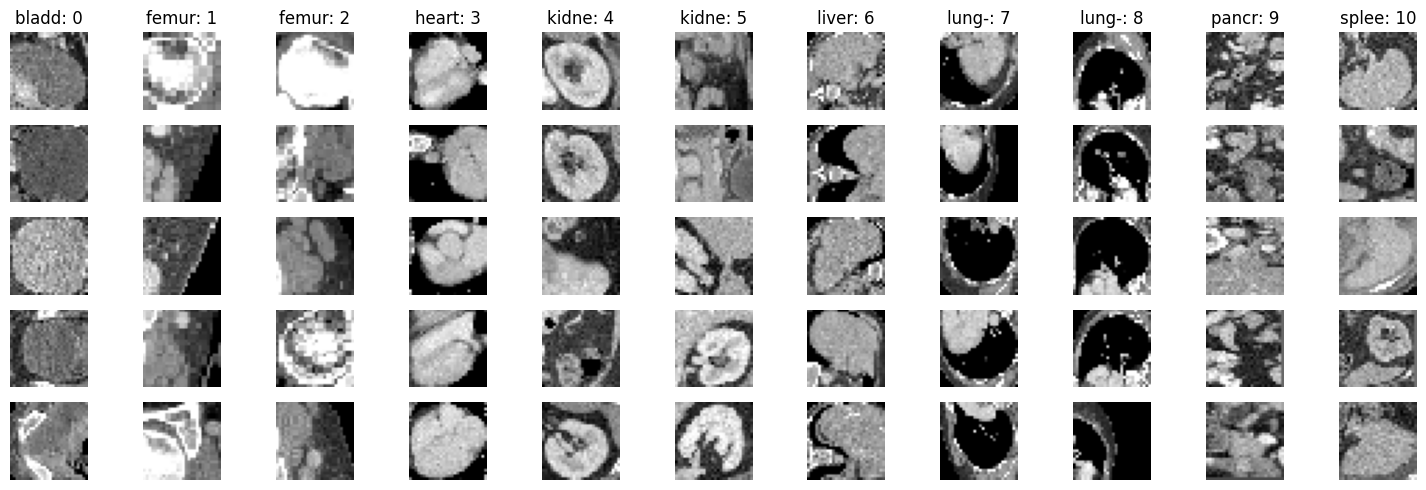

In [11]:

trainImages, trainLabels, trainInfo = trainDataset.__dict__['imgs'], trainDataset.__dict__['labels'], \
trainDataset.__dict__['info']['label']

print('Træningsdata:')
print(f'Billeder: {trainImages.shape}, Labels: {trainLabels.shape}')

valImages, valLabels = valDataset.__dict__['imgs'], valDataset.__dict__['labels']
print('Valideringsdata:')
print(f'Billeder: {valImages.shape}, Labels: {valLabels.shape}')

import matplotlib.pyplot as plt
import random

print('\n')
print('plot nogle eksempler:')

random.seed(42)
fig, axes = plt.subplots(5, len(trainInfo), figsize=(15, 5))

for class_, name in trainInfo.items():
    print(
        f'klasse: {class_}, klassenavn: {name}. Antal træning samples: {len(trainLabels[trainLabels == int(class_)])}')
    # Get indices of all images belonging to class i
    class_indices = [idx for idx, label in enumerate(trainLabels) if int(class_) == label]
    # Randomly select 5 indices
    selected_indices = random.sample(class_indices, 5)
    for j, idx in enumerate(selected_indices):
        image, label = trainImages[idx], trainLabels[idx]
        axes[j, int(class_)].imshow(image, cmap='gray')
        axes[j, int(class_)].axis('off')
        if j == 0:
            axes[j, int(class_)].set_title(f'{name[:5]}: {class_}')

plt.tight_layout()
plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True

To fulfill your request to classify the defined images using a CNN, we need to perform the following specific tasks:

1.  **Data Preparation**: Re-initialize the `OrganAMNIST` datasets with a transformation pipeline (converting images to PyTorch Tensors and normalizing them) and create `DataLoader` instances for batch processing.
2.  **Model Definition**: Create a Convolutional Neural Network (CNN) class with convolutional layers, pooling layers, and fully connected layers suitable for 28x28 grayscale images.
3.  **Training**: Implement a training loop to optimize the model using the training data and evaluate its accuracy on the validation data.

Here is the code to set up the data, define the model, and train it.

### 1. Data Preparation and Model Definition

First, we define the data transforms, data loaders, and the CNN architecture.



In [13]:
# Define transforms: Convert to Tensor and Normalize
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Re-load datasets with transforms for PyTorch compatibility
train_dataset_tensor = OrganAMNIST(split="train", transform=data_transform, download=True, size=28)
val_dataset_tensor = OrganAMNIST(split="val", transform=data_transform, download=True, size=28)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_tensor, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset_tensor, batch_size=64, shuffle=False)


# Define the CNN Architecture
class OrganCNN(nn.Module):
    def __init__(self, num_classes):
        super(OrganCNN, self).__init__()
        # Input is 1 channel (grayscale), 28x28
        self.features = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16 x 14 x 14

            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32 x 7 x 7

            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64 x 3 x 3
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Instantiate model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(trainInfo)
model = OrganCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model created. Device: {device}")
print(model)

Model created. Device: cuda
OrganCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=576, out_features=128, bias=True)
    (2)



### 2. Training and Evaluation

Now, we run the training loop for a few epochs and check the accuracy on the validation set.



In [21]:
num_epochs = 10

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        # Labels from MedMNIST are (N, 1), but CrossEntropyLoss expects (N)
        labels = labels.squeeze(1).long()

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Debugging check: Ensure batch sizes match
        if inputs.shape[0] != labels.shape[0]:
            print(f"Error found at step/index {i if 'i' in locals() else 'unknown'}")
            print(f"Inputs shape: {inputs.shape}")
            print(f"Labels shape: {labels.shape}")
            # Skip this batch or break to fix the data source
            continue 

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze().long()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

print("Training finished.")


Starting training...
Epoch [1/10], Loss: 0.0260, Validation Accuracy: 97.17%
Epoch [2/10], Loss: 0.0291, Validation Accuracy: 97.49%
Epoch [3/10], Loss: 0.0092, Validation Accuracy: 97.49%
Epoch [4/10], Loss: 0.0236, Validation Accuracy: 98.26%
Epoch [5/10], Loss: 0.0080, Validation Accuracy: 97.87%
Epoch [6/10], Loss: 0.0211, Validation Accuracy: 97.04%
Epoch [7/10], Loss: 0.0283, Validation Accuracy: 97.61%
Epoch [8/10], Loss: 0.0082, Validation Accuracy: 97.66%
Epoch [9/10], Loss: 0.0094, Validation Accuracy: 97.66%
Epoch [10/10], Loss: 0.0090, Validation Accuracy: 97.37%
Training finished.
